In [36]:
# import packages
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import Bio
import statsmodels.api as sm
from scipy.optimize import curve_fit
import pylab



Import datasets and define variables

In [37]:
# import data from computer
path: str = './data/' #folder where files are stored
prokaryotes: pd.DataFrame = pd.read_csv(os.path.join(path, "prokaryotes_unique_prot.csv"), dtype=str)   # imports file from the folder as species, based on name
prokaryotes_all: pd.DataFrame = pd.read_csv(os.path.join(path, "prokaryotes_all.csv"), dtype=str) # imports 3rd file from the folder, based on name

prokaryotes_all['temperature'] = prokaryotes_all['temperature'].astype('float64')
prokaryotes_all['fold_change'] = prokaryotes_all['fold_change'].astype('float64')
prokaryotes_all['Gene Ontology IDs'] = prokaryotes_all['Gene Ontology IDs'].astype('str')


In [39]:
prokaryotes_lysate = prokaryotes[prokaryotes['run_name'].str.contains('lysate')]
prokaryotes['meltPoint'] = prokaryotes['meltPoint'].astype('float64')
prokaryotes['Length'] = prokaryotes['Length'].astype('float64')

prokaryotes_grouped = prokaryotes_lysate.groupby('run_name')

mean_list = ['meltPoint', 'Length']
prokaryotes_grouped_mean = prokaryotes_grouped[mean_list].mean()

In [ ]:
print(prokaryotes_grouped_mean.corr())

           meltPoint   Length
meltPoint    1.00000 -0.61056
Length      -0.61056  1.00000


In [45]:
prokaryotes_Ecoli = prokaryotes[prokaryotes['run_name'].str.contains('Escherichia coli')]
prokaryotes_Thermus = prokaryotes[prokaryotes['run_name'].str.contains('Thermus thermophilus')]

In [48]:
print(prokaryotes_Ecoli[lambda x : x['meltPoint'] > 2000])

Empty DataFrame
Columns: [run_name, Organism, Protein_ID, Entry Name, gene_name, Protein names, Temperature dependence, Length, Sequence, temperature, fold_change, meltPoint, auc, Gene Ontology IDs, Gene Ontology (biological process), Gene Ontology (cellular component), Gene Ontology (molecular function), KEGG, EC number, Helix, Turn, Beta strand, AlphaFoldDB, PDB]
Index: []

[0 rows x 24 columns]


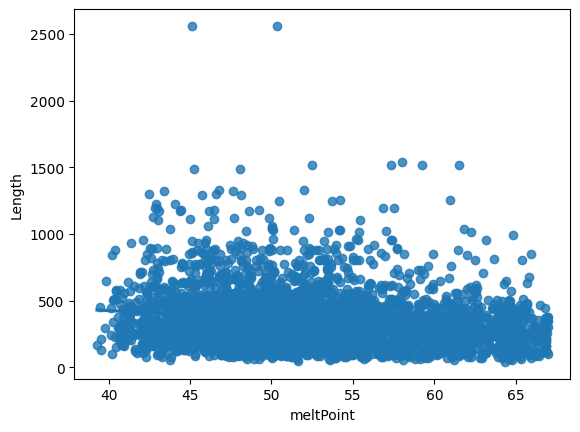

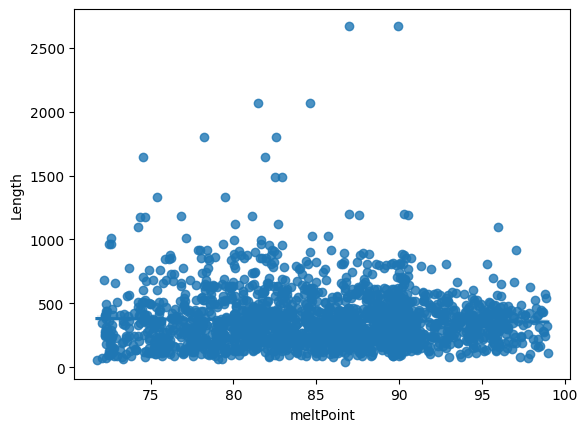

In [47]:
sns.regplot (data=prokaryotes_Ecoli, x='meltPoint', y='Length')
#plt.yscale('log')
plt.show()

sns.regplot (data=prokaryotes_Thermus, x='meltPoint', y='Length')
#plt.yscale('log')
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


TypeError: yscale() missing 1 required positional argument: 'value'

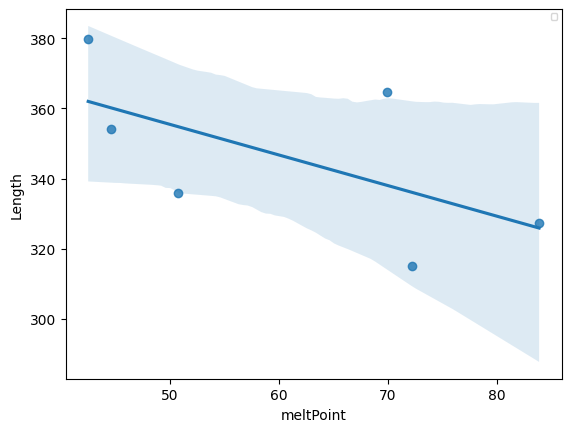

In [32]:
import matplotlib.pyplot as plt

# Your existing code to create the scatter plot
sns.regplot (data=prokaryotes_grouped_mean, x='meltPoint', y='Length')
plt.legend(loc='upper right',  prop={'size': 6})
plt.show()

Calculate sequence properties

In [ ]:
prokaryotes['meltPoint'] = prokaryotes['meltPoint'].astype('float64')
prokaryotes['auc'] = prokaryotes['auc'].astype('float64')
prokaryotes['temperature'] = prokaryotes['temperature'].astype('float64')
prokaryotes['Length'] = prokaryotes['Length'].astype('float64')
prokaryotes['meltPoint'] = prokaryotes['meltPoint'].dropna()

from function import rel_aa_comp
from Aminoacid_lists import AA_list, AA_acidic, AA_hydrophobic, AA_polar_neutral, AA_basic

for i in range(len(AA_list)):
    prokaryotes[str(AA_list[i])] = prokaryotes['Sequence'].apply(lambda x: rel_aa_comp(x, [str(AA_list[i])])) # calculates relative protein abundance

prokaryotes['AA_acidic'] = prokaryotes['Sequence'].apply(lambda x: rel_aa_comp(x, AA_acidic))
prokaryotes['AA_hydrophobic'] = prokaryotes['Sequence'].apply(lambda x: rel_aa_comp(x, AA_hydrophobic))
prokaryotes['AA_polar_neutral'] = prokaryotes['Sequence'].apply(lambda x: rel_aa_comp(x, AA_polar_neutral))
prokaryotes['AA_basic'] = prokaryotes['Sequence'].apply(lambda x: rel_aa_comp(x, AA_basic))

Bin proteins based on low, mid, high melters (as done in paper).
Average each bin 

In [ ]:
prokaryotes['binned'] = pd.cut(prokaryotes['auc'], bins = [0, 0.35, 0.65, 1.5], labels = ['low', 'medium', 'high'])

mean_list = ['A', 'V', 'I', 'L', 'M', 'F', 'W', 'N', 'Q', 'S', 'T', 'Y', 'D', 'E', 'R', 'H', 'K', 'C', 'P', 'G', 
             'AA_acidic', 'AA_basic', 'AA_hydrophobic', 'AA_polar_neutral', 'meltPoint', 'temperature', 'auc', 'Length']
prokaryotes_AUCgroup = prokaryotes.groupby(by = 'binned')
prokaryotes_AUCgroup_mean = prokaryotes_AUCgroup[mean_list].mean()

prokaryotes_AUCgroup_mean_corr = prokaryotes_AUCgroup_mean.corr()


In [ ]:
print(f"Bin size \n {prokaryotes_AUCgroup.size()} \n \n"
    f"Average AUC \n low, medium, high \n{prokaryotes_AUCgroup_mean['auc'].unique()}"
    f"\n \n Average meltPoint \n low, medium, high \n{prokaryotes_AUCgroup_mean['meltPoint'].unique()}")


In [ ]:
sns.barplot(data = prokaryotes_AUCgroup_mean_corr, x = prokaryotes_AUCgroup_mean_corr.columns, y = 'meltPoint')
plt.xticks(rotation = 90)
plt.xlabel('Binned, averaged')
plt.show()

In [ ]:
prokaryotes_cells = prokaryotes[prokaryotes['run_name'].str.contains('cell')]
prokaryotes_lysate = prokaryotes[prokaryotes['run_name'].str.contains('lysate')]

prokaryotes_cells['meltPoint'] = prokaryotes_cells['meltPoint'].astype('float64')
prokaryotes_lysate['meltPoint'] = prokaryotes_lysate['meltPoint'].astype('float64')


prokaryotes_cells['binned'] = pd.cut(prokaryotes_cells['auc'], bins = [0, 0.35, 0.65, 1.5], labels = ['low', 'medium', 'high'])

mean_list = ['A', 'V', 'I', 'L', 'M', 'F', 'W', 'N', 'Q', 'S', 'T', 'Y', 'D', 'E', 'R', 'H', 'K', 'C', 'P', 'G', 
             'AA_acidic', 'AA_basic', 'AA_hydrophobic', 'AA_polar_neutral']
prokaryotes_cells_AUCgroup = prokaryotes_cells.groupby(by = 'binned')
prokaryotes_cells_AUCgroup_mean = prokaryotes_cells_AUCgroup[mean_list].mean()
prokaryotes_cells_AUCgroup_mean_corr = prokaryotes_cells_AUCgroup_mean.corr()



prokaryotes_lysate['binned'] = pd.cut(prokaryotes_lysate['auc'], bins = [0, 0.35, 0.65, 1.5], labels = ['low', 'medium', 'high'])
prokaryotes_lysate_AUCgroup = prokaryotes_lysate.groupby(by = 'binned')
prokaryotes_lysate_AUCgroup_mean = prokaryotes_lysate_AUCgroup[mean_list].mean()
prokaryotes_lysate_AUCgroup_mean_corr = prokaryotes_lysate_AUCgroup_mean.corr()




In [ ]:
sns.barplot(data = prokaryotes_cells_AUCgroup_mean_corr, x = prokaryotes_cells_AUCgroup_mean_corr.columns, y = 'meltPoint')
plt.xticks(rotation = 90)
plt.xlabel('Binned, averaged; cells only')
plt.show()

sns.barplot(data = prokaryotes_lysate_AUCgroup_mean_corr, x = prokaryotes_lysate_AUCgroup_mean_corr.columns, y = 'meltPoint')
plt.xticks(rotation = 90)
plt.xlabel('Binned, averaged; lysate only')
plt.show()